In [1]:
!pip install pyproj
!pip install cartopy
!pip install tensorflow

  Using cached tensorflow-2.8.0-cp39-cp39-manylinux2010_x86_64.whl (497.6 MB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached gast-0.5.3-py3-none-any.whl (19 kB)
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorflow_io_gcs_filesystem-0.24.0-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.1 MB)
  Using cached wrapt-1.13.3-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (81 kB)
  Using cached libclang-13.0.0-py2.py3-none-manylinux1_x86_64.whl (14.5 MB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Us

In [2]:
%matplotlib inline

In [3]:
import gzip
import shutil 
import numpy as np
import gzip
import os
from pathlib import Path
import shutil

In [4]:
from datetime import datetime, timedelta
from urllib.request import urlopen
!pip install metpy

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from metpy.units import masked_array, units
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import tensorflow as tf

2022-03-10 02:47:33.375489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-10 02:47:33.376269: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


prep 1 tf record

In [5]:
#row = next(iter(reader(split="train", variant="256")))
#print(row["radar_frames"].numpy())

In [6]:
def parse(element):
    print('parsing')
    
    '''
     "radar": bytes_feature(serialize_array(example)), # tf.string
        "sample_prob": float_feature(1.),  # tf.float32
        "central_latitude":int64_feature(int(90.0)),
        "central_longitude":int64_feature(int(metadata.straight_vertical_longitude_from_pole)),
        "true_scale_latitude":int64_feature(int(metadata.standard_parallel)),
        "earth_radius":int64_feature(int(metadata.earth_radius))
    '''
    features = {
      'central_longitude': tf.io.FixedLenFeature([], tf.int64), 
      'central_latitude':tf.io.FixedLenFeature([], tf.int64),
      'radar' : tf.io.FixedLenFeature([], tf.string),
      'true_scale_latitude':tf.io.FixedLenFeature([], tf.int64),
      'earth_radius':tf.io.FixedLenFeature([], tf.int64),
      'x':tf.io.FixedLenFeature([], tf.string),
      'y':tf.io.FixedLenFeature([], tf.string),
        
    }
    
    
    result = tf.io.parse_single_example(element, features) 
    radar_bytes = result['radar']#result.pop("radar")
    shape = (881, 1121)

    radar_float64 = tf.reshape(tf.io.parse_tensor(radar_bytes, tf.float32), shape)
    print('radar bytes')
    print(radar_bytes)
    #mask = tf.not_equal(radar_float64, _INT16_MASK_VALUE)
    
    '''
    #get our 'feature'-- our image -- and reshape it appropriately
    feature = tf.io.parse_tensor(radar, out_type=tf.int16)
    feature = tf.reshape(feature, shape=[256,256,1])
    return (feature, label)
    '''
    #result["radar_frames"] = radar_float64
    #result["radar_mask"] = mask
    result['x'] = tf.io.parse_tensor(result['x'], tf.float64) 
    result['y'] = tf.io.parse_tensor(result['y'], tf.float64)
    print(result)
    
    return {'radar':radar_float64,
            'central_longitude':result['central_longitude'],
            'central_latitude':result['central_latitude'],
            'true_scale_latitude':result['true_scale_latitude'],
            "x":result["x"],
            "y":result["y"],
            'earth_radius': result['earth_radius']}

In [7]:
def get_dataset_small(filename):
  #create the dataset
  #dataset = tf.data.TFRecordDataset(filename)

  #pass every single feature through our mapping function
  #dataset = dataset.map(
  #    parse_tfr_element
  #)
    dataset = tf.data.TFRecordDataset(filename, compression_type="GZIP") 
   
    print(dataset)
    '''
    for raw_record in dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        print(example)
    '''
    dataset = dataset.map(parse)

    return dataset

#dataset_small = get_dataset_small("./2020-03-15_15842627.tfrecord.gz")
dataset_small = get_dataset_small("./prepMaptest3_1.tfrecord.gz")


#print(dataset_small)
row = next(iter(dataset_small))

#print(row)
#print(row['radar'].numpy())
#print(dataset_small['radar'])

2022-03-10 02:47:35.712384: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-10 02:47:35.712447: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-10 02:47:35.712870: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ba8224dd7c90): /proc/driver/nvidia/version does not exist
2022-03-10 02:47:35.713933: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
parsing
radar bytes
Tensor("ParseSingleExample/ParseExample/ParseExampleV2:3", shape=(), dtype=string)
{'central_latitude': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:0' shape=() dtype=int64>, 'central_longitude': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:1' shape=() dtype=int64>, 'earth_radius': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:2' shape=() dtype=int64>, 'radar': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:3' shape=() dtype=string>, 'true_scale_latitude': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:4' shape=() dtype=int64>, 'x': <tf.Tensor 'ParseTensor_1:0' shape=<unknown> dtype=float64>, 'y': <tf.Tensor 'ParseTensor_2:0' shape=<unknown> dtype=float64>}


In [8]:
row['central_latitude'].numpy()

90

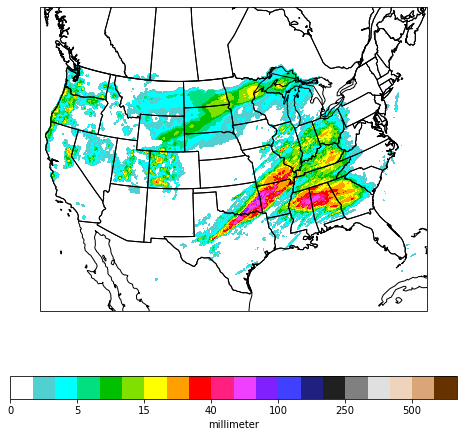

In [9]:
def graphMrms(row):
    globe = ccrs.Globe(semimajor_axis=row['earth_radius'].numpy()) 
    proj = ccrs.Stereographic(central_latitude=row['central_latitude'].numpy(), 
                        central_longitude= row['central_longitude'].numpy() ,
                        true_scale_latitude=row['true_scale_latitude'].numpy(), 
                        globe=globe)
 
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    # draw coastlines, state and country boundaries, edge of map.
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES)

    # draw filled contours.
    clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
             50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
    # In future MetPy
    # norm, cmap = ctables.registry.get_with_boundaries('precipitation', clevs)
    cmap_data = [(1.0, 1.0, 1.0),
                 (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
                 (0.0, 1.0, 1.0),
                 (0.0, 0.8784313797950745, 0.501960813999176),
                 (0.0, 0.7529411911964417, 0.0),
                 (0.501960813999176, 0.8784313797950745, 0.0),
                 (1.0, 1.0, 0.0),
                 (1.0, 0.6274510025978088, 0.0),
                 (1.0, 0.0, 0.0),
                 (1.0, 0.125490203499794, 0.501960813999176),
                 (0.9411764740943909, 0.250980406999588, 1.0),
                 (0.501960813999176, 0.125490203499794, 1.0),
                 (0.250980406999588, 0.250980406999588, 1.0),
                 (0.125490203499794, 0.125490203499794, 0.501960813999176),
                 (0.125490203499794, 0.125490203499794, 0.125490203499794),
                 (0.501960813999176, 0.501960813999176, 0.501960813999176),
                 (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
                 (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
                 (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
                 (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
                 (0.4000000059604645, 0.20000000298023224, 0.0)]
    cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    norm = mcolors.BoundaryNorm(clevs, cmap.N)

    data = row['radar']#[500:950, 800:1100] 
    x = row['x']#nc.variables['x'][:]
    y = row['y']#nc.variables['y'][:]

    cs = ax.contourf(x, y, data, clevs, cmap=cmap, norm=norm)

    # add colorbar.
    cbar = plt.colorbar(cs, orientation='horizontal')
    cbar.set_label("millimeter")

    
    # cropp data 
    
    #ax.set_title(prcpvar.long_name + ' for period ending ' + nc.creation_time)
    plt.show()
graphMrms(row)

In [10]:
row['radar']

<tf.Tensor: shape=(881, 1121), dtype=float32, numpy=
array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       ...,
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38]], dtype=float32)>

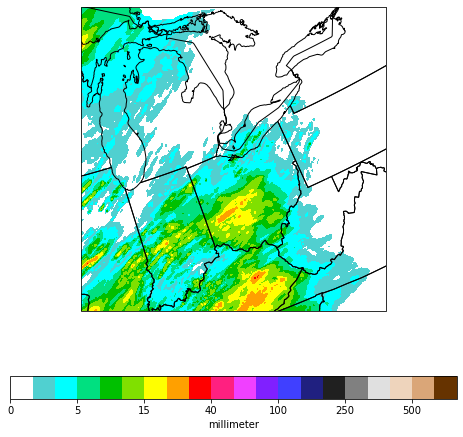

In [11]:
tmp = row.copy()
tmp['radar'] = tmp['radar'][200:450, 700:950] 
tmp['x'] = tmp['x'][700:950]
tmp['y'] = tmp['y'][200:450]

graphMrms(tmp)

In [12]:
x = row['x']
x

<tf.Tensor: shape=(1121,), dtype=float64, numpy=
array([-1902530.61073866, -1897767.61073866, -1893004.61073866, ...,
        3422503.38926134,  3427266.38926134,  3432029.38926134])>

In [13]:
print(len(row['x']) )
print( len(row['y'] ))

1121
881


In [14]:
y = row['y']
y

<tf.Tensor: shape=(881,), dtype=float64, numpy=
array([-3426165.19569394, -3430928.19569394, -3435691.19569394,
       -3440454.19569394, -3445217.19569394, -3449980.19569394,
       -3454743.19569394, -3459506.19569394, -3464269.19569394,
       -3469032.19569394, -3473795.19569394, -3478558.19569394,
       -3483321.19569394, -3488084.19569394, -3492847.19569394,
       -3497610.19569394, -3502373.19569394, -3507136.19569394,
       -3511899.19569394, -3516662.19569394, -3521425.19569394,
       -3526188.19569394, -3530951.19569394, -3535714.19569394,
       -3540477.19569394, -3545240.19569394, -3550003.19569394,
       -3554766.19569394, -3559529.19569394, -3564292.19569394,
       -3569055.19569394, -3573818.19569394, -3578581.19569394,
       -3583344.19569394, -3588107.19569394, -3592870.19569394,
       -3597633.19569394, -3602396.19569394, -3607159.19569394,
       -3611922.19569394, -3616685.19569394, -3621448.19569394,
       -3626211.19569394, -3630974.19569394, -3635737.19

test pynb tf record

In [15]:
def parsegrib(element):
    print('parsing')
    
    '''
    "radar": bytes_feature(serialize_array(example)), # tf.string
        "sample_prob": float_feature(1.),  # tf.float32
        "lonmin": int64_feature(int(metadata['GRIB_longitudeOfFirstGridPointInDegrees'])),#(metadata[0].latlong_box[0]), # tf.int64
        "lonmax": int64_feature(int(metadata['GRIB_longitudeOfLastGridPointInDegrees'])),#(metadata[0].latlong_box[1]), # tf.int64
        "latmin": int64_feature(int(metadata['GRIB_latitudeOfFirstGridPointInDegrees'])),#(metadata[0].latlong_box[2]), # tf.int64
        "latmax": int64_feature(int(metadata['GRIB_latitudeOfLastGridPointInDegrees']))#(metadata[0].latlong_box[3]), # tf.int64
 
    '''
    features = {
      'latmin': tf.io.FixedLenFeature([], tf.int64), 
      'latmax':tf.io.FixedLenFeature([], tf.int64),
      'radar' : tf.io.FixedLenFeature([], tf.string),
      'latitude' : tf.io.FixedLenFeature([], tf.string),
      'longitude' : tf.io.FixedLenFeature([], tf.string),
        
      'lonmin':tf.io.FixedLenFeature([], tf.int64),
      'lonmax':tf.io.FixedLenFeature([], tf.int64) 
        
    }
    
    
    result = tf.io.parse_single_example(element, features) 
    radar_bytes = result['radar']#result.pop("radar")
    shape = (3500, 7000)

    radar_float32 = tf.reshape(tf.io.parse_tensor(radar_bytes, tf.float32), shape)
    print('radar bytes')
    print(radar_bytes)
    result['latitude'] = tf.io.parse_tensor(result['latitude'], tf.float64) 
    result['longitude'] = tf.io.parse_tensor(result['longitude'], tf.float64)
    
    '''
    #get our 'feature'-- our image -- and reshape it appropriately
    feature = tf.io.parse_tensor(radar, out_type=tf.int16)
    feature = tf.reshape(feature, shape=[256,256,1])
    return (feature, label)
    '''
    #result["radar_frames"] = radar_float64
    #result["radar_mask"] = mask
    #result['x'] = tf.io.parse_tensor(result['x'], tf.float64) 
    #result['y'] = tf.io.parse_tensor(result['y'], tf.float64)
    #print(result)
    
    return {'radar':radar_float32,
            'latmin':result['latmin'],
            'latmax':result['latmax'],
            'lonmin':result['lonmin'], 
            'lonmax': result['lonmax'],
            'longitude':result['longitude'] ,
            'latitude':result['latitude']}

In [16]:
def get_dataset_grib(filename):
  #create the dataset
  #dataset = tf.data.TFRecordDataset(filename)

  #pass every single feature through our mapping function
  #dataset = dataset.map(
  #    parse_tfr_element
  #)
    dataset = tf.data.TFRecordDataset(filename, compression_type="GZIP") 
   
    print(dataset) 
    dataset = dataset.map(parsegrib)

    return dataset

#dataset_small = get_dataset_small("./2020-03-15_15842627.tfrecord.gz")
dataset_grib = get_dataset_grib("./map_1.tfrecord.gz")


print(dataset_grib)
gribrow = next(iter(dataset_grib))

print(gribrow)
#print(row['radar'].numpy())
#print(dataset_small['radar'])

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
parsing
radar bytes
Tensor("ParseSingleExample/ParseExample/ParseExampleV2:6", shape=(), dtype=string)
<MapDataset element_spec={'radar': TensorSpec(shape=(3500, 7000), dtype=tf.float32, name=None), 'latmin': TensorSpec(shape=(), dtype=tf.int64, name=None), 'latmax': TensorSpec(shape=(), dtype=tf.int64, name=None), 'lonmin': TensorSpec(shape=(), dtype=tf.int64, name=None), 'lonmax': TensorSpec(shape=(), dtype=tf.int64, name=None), 'longitude': TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), 'latitude': TensorSpec(shape=<unknown>, dtype=tf.float64, name=None)}>
{'radar': <tf.Tensor: shape=(3500, 7000), dtype=float32, numpy=
array([[-3., -3., -3., ..., -3., -3., -3.],
       [-3., -3., -3., ..., -3., -3., -3.],
       [-3., -3., -3., ..., -3., -3., -3.],
       ...,
       [-3., -3., -3., ..., -3., -3., -3.],
       [-3., -3., -3., ..., -3., -3., -3.],
       [-3., -3., -3., ..., -3., -3., -3.]], 

[[-3. -3. -3. ... -3. -3. -3.]
 [-3. -3. -3. ... -3. -3. -3.]
 [-3. -3. -3. ... -3. -3. -3.]
 ...
 [-3. -3. -3. ... -3. -3. -3.]
 [-3. -3. -3. ... -3. -3. -3.]
 [-3. -3. -3. ... -3. -3. -3.]]


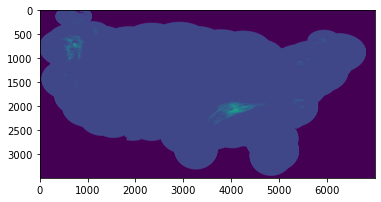

In [17]:
print(gribrow['radar'].numpy())
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(gribrow['radar'].numpy())

In [18]:
#crop 256,256 : 
latitude =  gribrow['latitude'].numpy().copy()  
longitude =  gribrow['longitude'].numpy().copy()  
mrms =  gribrow['radar'].numpy().copy() 
mrms 

array([[-3., -3., -3., ..., -3., -3., -3.],
       [-3., -3., -3., ..., -3., -3., -3.],
       [-3., -3., -3., ..., -3., -3., -3.],
       ...,
       [-3., -3., -3., ..., -3., -3., -3.],
       [-3., -3., -3., ..., -3., -3., -3.],
       [-3., -3., -3., ..., -3., -3., -3.]], dtype=float32)

In [19]:
latitude  = latitude[500:750] 
longitude = longitude[4500:4750]

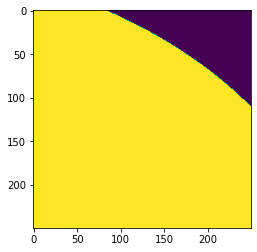

In [20]:
#mrms = mrms[500:750,4500:4750]
plt.imshow( mrms[500:750,4500:4750]  )


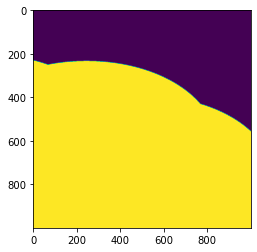

In [21]:
plt.imshow( mrms[200:1200,4000:5000]  )
